In [1]:
#Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#Set up the environment

# Environment definition
np.random.seed(39)

T = 10000 # Horizon

#Parameters for prices
alpha = 0.5
beta = 1.5

factors = np.array([alpha**2,alpha,1,beta,beta**2])
choices = len(factors)


#Choose price parameter P uniformly from the range [1.5,2.5]
P = np.random.uniform(1.5,2.5)
prices = P*factors
print(f'Prices: {prices}')

eta = np.sqrt(np.log(choices)/T)


Prices: [0.51172229 1.02344458 2.04688916 3.07033373 4.6055006 ]


In [9]:

#Question 1: Multiplicative Weights Algorithm for users who choose randomly
def simulate_random_choice(T,prices,eta):

    actions = len(prices)
    w = np.ones(actions) #Set inital weights to 1 for each expert
    cumulative_rewards = np.zeros(T) #Array to store total reward after each time step
    probability_history = np.zeros((T,actions)) #Array to store probability of each action at each time step
    chosen_actions = np.zeros(T,dtype=int)

    cumulative_reward = 0

    for t in range(T):

        probabilities = w / np.sum(w) #Probability for each expert
        probability_history[t] = probabilities

        action = np.random.choice(actions, p=probabilities)
        chosen_actions[t] = action
        suggestion = prices[action]

        #User picks randomly from the suggestions
        user_choice = np.random.choice(["seller","competitor"])
        reward = suggestion if user_choice == "seller" else 0

        #Update cumulative reward
        cumulative_reward += reward
        cumulative_rewards[t] = cumulative_reward

        expected_reward = reward / probabilities[action]
        w[action] *= (1 - eta) ** (-expected_reward) #Update weights

    return cumulative_rewards, probability_history, w

In [10]:
#Question 2: Multiplicative Weights Algorithm for users who choose in a smart way
def simulate_smart_user(T, prices, eta):
    """
      - For the first T/4 rounds, the user picks randomly.
      - For the remaining rounds, the user asks both sellers and selects the lower price.
    """
    actions = len(prices)
    w = np.ones(actions)
    cumulative_rewards = np.zeros(T) #Array to store total reward after each time step
    probability_history = np.zeros((T,actions)) #Array to store probability of each action at each time step
    chosen_actions = np.zeros(T,dtype=int)


    cumulative_reward = 0

    for t in range(T):
        # Compute the probability distribution over actions
        probs = w / np.sum(w)
        probability_history[t] = probs

        # Select an action based on the computed probabilities
        action = np.random.choice(actions, p=probs)
        our_price = prices[action]

        # Determine reward based on phase
        if t < T / 4:
            # Naive phase: user picks randomly between "us" and "competitor"
            user_choice = np.random.choice(["seller", "competitor"])
            reward = our_price if user_choice == "seller" else 0
        else:
            # Smart phase: competitor's price drawn uniformly from [0,4]
            competitor_price = np.random.uniform(0, 4)
            # User picks the seller with the lower price
            reward = our_price if our_price < competitor_price else 0

        # Update cumulative reward
        cumulative_reward += reward
        cumulative_rewards[t] = cumulative_reward

        # Alternative weight update (adjusted to profits)
        w[action] *= (1 - eta) ** (-reward / probs[action])

    return cumulative_rewards, probability_history, w



Total cumulative reward (Naive User): 22537.784776025863
Total cumulative reward (Smart User): 5537.346889662126


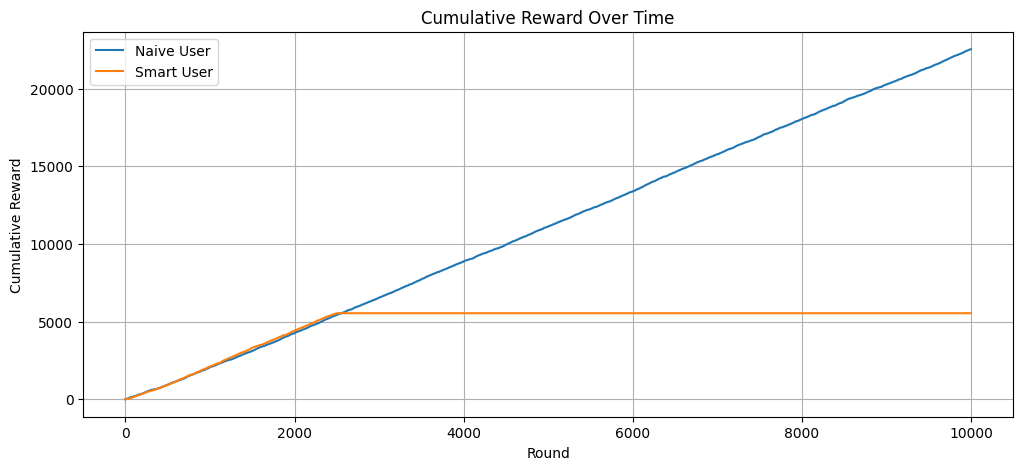

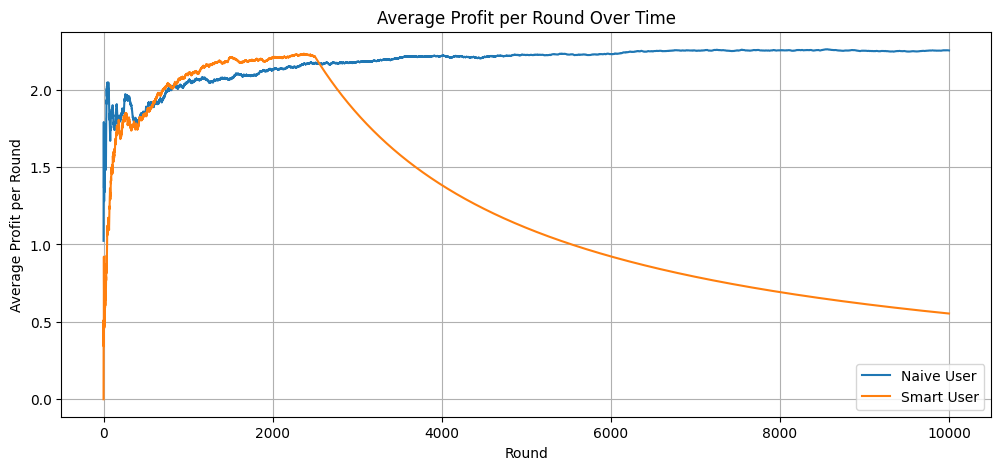

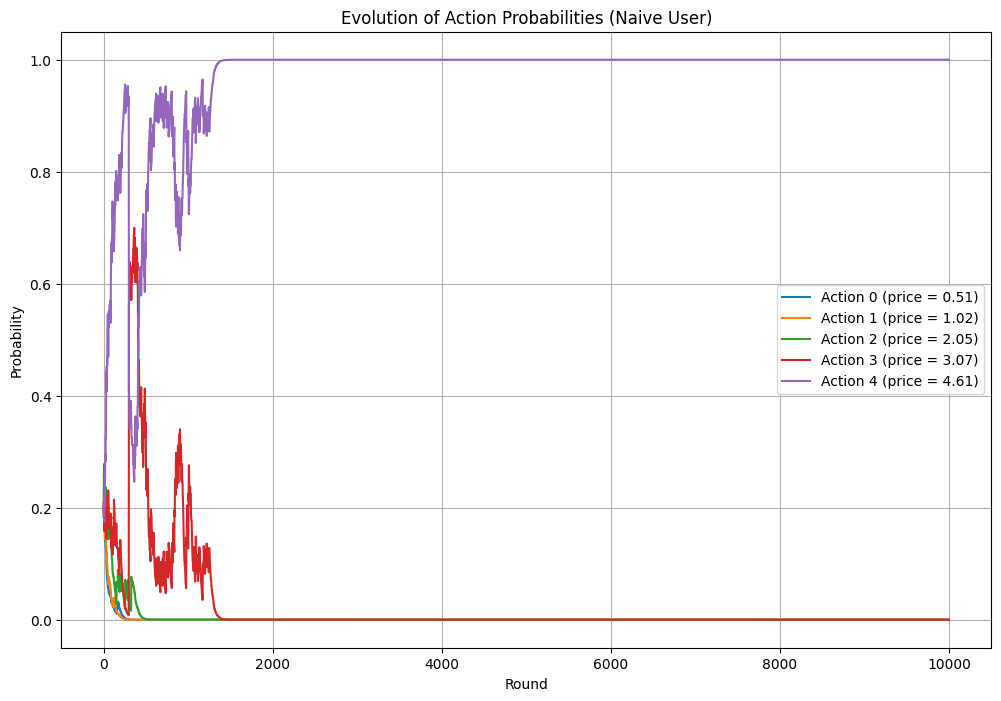

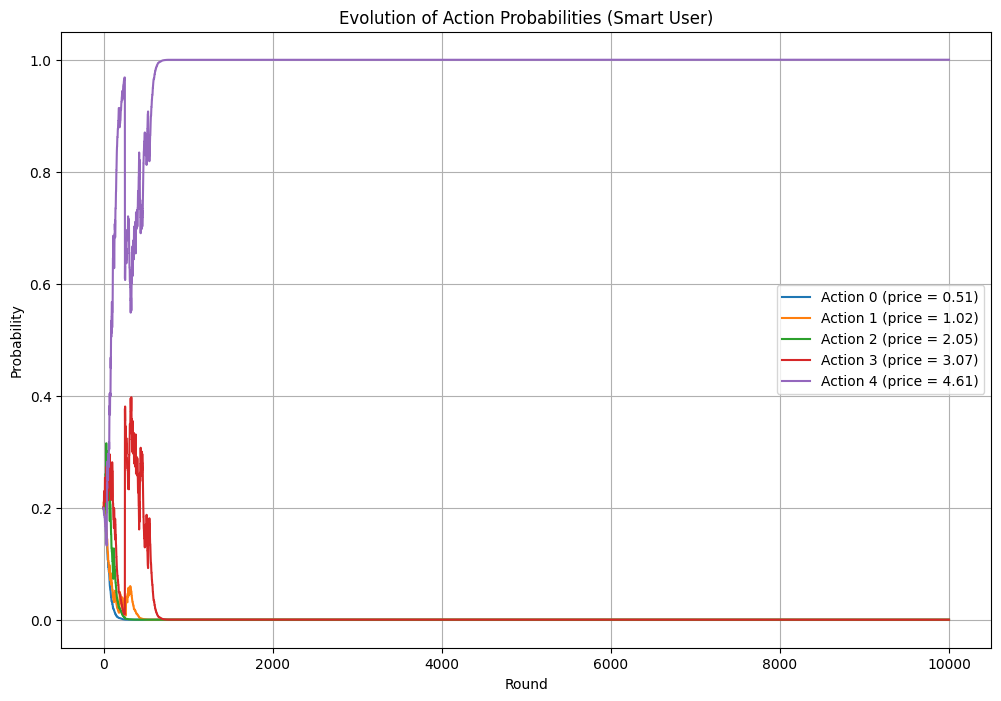

In [11]:
cumulative_rewards_naive, probs_history_naive, final_weights_naive = simulate_random_choice(T, prices, eta)
cumulative_rewards_smart, probs_history_smart, final_weights_smart = simulate_smart_user(T, prices, eta)

#Average profit per round for each scenario
avg_profit_naive = cumulative_rewards_naive / (np.arange(T) + 1)
avg_profit_smart = cumulative_rewards_smart / (np.arange(T) + 1)

# Print final action probabilities for both cases
final_probs_naive = probs_history_naive[-1]
final_probs_smart = probs_history_smart[-1]
print("Total cumulative reward (Naive User):", cumulative_rewards_naive[-1])
print("Total cumulative reward (Smart User):", cumulative_rewards_smart[-1])

# Plot cumulative rewards for both scenarios
plt.figure(figsize=(12, 5))
plt.plot(cumulative_rewards_naive, label='Naive User')
plt.plot(cumulative_rewards_smart, label='Smart User')
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot average profit per round for both scenarios
plt.figure(figsize=(12, 5))
plt.plot(avg_profit_naive, label='Naive User')
plt.plot(avg_profit_smart, label='Smart User')
plt.xlabel("Round")
plt.ylabel("Average Profit per Round")
plt.title("Average Profit per Round Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot evolution of action probabilities for the naive user scenario
plt.figure(figsize=(12, 8))
for i in range(choices):
    plt.plot(probs_history_naive[:, i], label=f"Action {i} (price = {prices[i]:.2f})")
plt.xlabel("Round")
plt.ylabel("Probability")
plt.title("Evolution of Action Probabilities (Naive User)")
plt.legend()
plt.grid(True)
plt.show()

# Plot evolution of action probabilities for the smart user scenario
plt.figure(figsize=(12, 8))
for i in range(choices):
    plt.plot(probs_history_smart[:, i], label=f"Action {i} (price = {prices[i]:.2f})")
plt.xlabel("Round")
plt.ylabel("Probability")
plt.title("Evolution of Action Probabilities (Smart User)")
plt.legend()
plt.grid(True)
plt.show()

#Report on the results

In this assignment, our task was to pick the correct price for our service between 4 different options in order to maximize the profit. Each possible price consists of a base value P and
a constant factor a or b.

For this experiment, the following parameters were used:
- \(a = 0.5\), \(b = 1.5\).
- The pricing options were:
1. P = a^2*P
2. P = a*P
3. P = *P
4. P = b^2*P
5. P = b^2*P
- Base price \(P\) sampled uniformly from \([1.5, 2.5]\).
- Competitor price \(Q\) sampled uniformly from \([0,4]\) at each round.
- The horizon parameter T was set to 10000 users

---

## 1. Naive User Scenario

### 1.1 Description
- For all 10,000 rounds, each arriving user picks randomly between our service and the competitor, ignoring the price.

### 1.2 Observations
- **Policy Learned:** MW quickly converges to the **highest price option**. Since the user is equally likely to choose us regardless of price, setting a higher price yields a higher reward when chosen.
- **Cumulative Reward:** The total profit grows **approximately linearly** once the algorithm settles on the highest price, because each round we have a 50% chance of receiving that high price.
- **Profit Per Round:** Stabilizes near \(0.5 \times (b^2 P)\), which is the best achievable when the user is indifferent to price.

### 1.3 Conclusion
- In the naive user case, our final average profit per round is **relatively high** because the user does not penalize us for overpricing.

---

## 2. Smart User Scenario

### 2.1 Description
- For the first \(T/4 = 2{,}500\) rounds, the user picks randomly (same as the naive scenario).
- **After round 2,500**, the user becomes “smart”: she requests prices from both sellers and **chooses the lower price**.

### 2.2 Observations
- **Phase 1 (Rounds 1–2,500):** As in the naive scenario, MW starts to favor the **highest price**.
- **Behavior Change (After Round 2,500):** Once the user compares prices, a high price rarely wins (competitor is cheaper often). MW observes little reward and **shifts** to lower-priced actions.
- **Steady-State Pricing:** Eventually, MW settles near **mid-range prices** (often around \(p_2 = P\)), striking a balance between being low enough to win and high enough to earn decent revenue.
- **Overall Profit:** The cumulative reward is **lower** than in the naive scenario. Even after re-learning, the best average profit per round is smaller because you must compete on price.

### 2.3 Conclusion
- The smart user’s willingness to compare and choose the cheaper option **reduces** our per-round profit.  
- The transition period (when the user behavior changes) causes an **adaptation cost** in MW’s learning, temporarily lowering cumulative profit further.

---

## 3. Final Comparison

- **Naive vs. Smart:**
  - **Naive user** yields a **higher** final profit since overpricing is never punished.  
  - **Smart user** forces us to lower prices to win sales, thereby decreasing total earnings.

- **Key Takeaway:**
  - If users are **price-insensitive** (naive), it is optimal to set the highest price.  
  - If users are **price-sensitive** (smart), the optimal price must be lower to remain competitive, reducing profit.
